# Mask R-CNN - Train on Shapes Dataset

### Notes from implementation

This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 


### Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import pprint
import keras.backend as KB
sys.path.append('../')

import mrcnn.model     as modellib
import mrcnn.visualize as visualize
import mrcnn.shapes    as shapes
from mrcnn.config      import Config
from mrcnn.model       import log
from mrcnn.dataset     import Dataset 
# from mrcnn.pc_layer    import PCTensor
from mrcnn.pc_layer   import PCNLayer

# Root directory of the project
ROOT_DIR = os.getcwd()
MODEL_PATH = 'E:\Models'
# Directory to save logs and trained model
MODEL_DIR = os.path.join(MODEL_PATH, "mrcnn_logs")
# Path to COCO trained weights
COCO_MODEL_PATH   = os.path.join(MODEL_PATH, "mask_rcnn_coco.h5")
RESNET_MODEL_PATH = os.path.join(MODEL_PATH, "resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5")

print("Tensorflow Version: {}   Keras Version : {} ".format(tf.__version__,keras.__version__))
pp = pprint.PrettyPrinter(indent=2, width=100)
np.set_printoptions(linewidth=100)

# Build configuration object -----------------------------------------------
config = shapes.ShapesConfig()
config.BATCH_SIZE      = 2                    #Batch size is 2 (# GPUs * images/GPU).
config.IMAGES_PER_GPU  = 2
config.STEPS_PER_EPOCH = 7
# config.IMAGES_PER_GPU  = 1
config.display() 

# Build shape dataset        -----------------------------------------------

from mrcnn.datagen import data_generator, load_image_gt

# Training dataset
# generate 500 shapes 
dataset_train = shapes.ShapesDataset()
dataset_train.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Validation dataset
dataset_val = shapes.ShapesDataset()
dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

# Load and display random samples
# image_ids = np.random.choice(dataset_train.image_ids, 3)
# for image_id in [3]:
#     image = dataset_train.load_image(image_id)
#     mask, class_ids = dataset_train.load_mask(image_id)
#     visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Tensorflow Version: 1.4.0   Keras Version : 2.1.3 

Configurations:
BACKBONE_SHAPES                [[32 32]
 [16 16]
 [ 8  8]
 [ 4  4]
 [ 2  2]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  128
IMAGE_MIN_DIM                  128
IMAGE_PADDING                  True
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           shapes
NUM

## Create Model

In [2]:
# import importlib
# importlib.reload(model)
# Create model in training mode
# MODEL_DIR = os.path.join(MODEL_PATH, "mrcnn_logs")
import  gc
# del history
try :
    del model
except: 
    pass
 
gc.collect()

model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

#model.keras_model.summary(line_length = 120)

# print(MODEL_PATH)
print(COCO_MODEL_PATH)
# print(RESNET_MODEL_PATH)
print(' Checkpoint folder: ', MODEL_DIR)
print(model.find_last())

# Which weights to start with?
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
#     loc=model.load_weights(model.get_imagenet_weights(), by_name=True)
    loc=model.load_weights(RESNET_MODEL_PATH, by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    
    # See README for instructions to download the COCO weights
    loc=model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    loc= model.load_weights(model.find_last()[1], by_name=True)
print('>>> Load weights complete')


train_generator = data_generator(dataset_train, model.config, shuffle=True,
                                 batch_size=model.config.BATCH_SIZE,
                                 augment = False)
val_generator = data_generator(dataset_val, model.config, shuffle=True, 
                                batch_size=model.config.BATCH_SIZE,
                                augment=False)

set_log_dir: Checkpoint path set to : E:\Models\mrcnn_logs\shapes20180328T1958\mask_rcnn_shapes_{epoch:04d}.h5
 IMAGE SHAPE is : 128    128
<class 'list'>
Tensor("rpn_class_logits/concat:0", shape=(?, ?, 2), dtype=float32) rpn_class_logits/concat:0
Tensor("rpn_class/concat:0", shape=(?, ?, 2), dtype=float32) rpn_class/concat:0
Tensor("rpn_bbox/concat:0", shape=(?, ?, 4), dtype=float32) rpn_bbox/concat:0
Proposal Layer init complete. Size of anchors:  (4092, 4)
>>> Detection Target Layer : initialization
>>> Detection Target Layer : call 
>>> Detection Target Layer : return call  <class 'list'>
>>> PCN Layer : initialization
>>> PCN Layer : call
     mrcnn_class.shape    : (?, 32, 4) <class 'tensorflow.python.framework.ops.Tensor'>
     mrcnn_bbox.shape     : (?, 32, 4, 4) <class 'tensorflow.python.framework.ops.Tensor'>
     output_rois.shape    : (2, ?, ?) <class 'tensorflow.python.framework.ops.Tensor'>
>>> PCN Layer : call end  
>>> MaskRCNN build complete
>>> MaskRCNN initializatio

## Process outside of training 

In [3]:
model.compile_only(learning_rate=config.LEARNING_RATE, layers='heads')
# print(KB.eval(KB.learning_phase()))
KB.set_learning_phase(1)
print(' Learning phase values is L ' ,KB.learning_phase())
mm = model.keras_model
print('\n Metrics (_get_deduped_metrics_names():) ') 
pp.pprint(mm._get_deduped_metrics_names())
print('\n Outputs: ') 
pp.pprint(mm.outputs)
# pp.pprint(mm.fit_generator.__dict__['__wrapped__'])

print('\n Losses (model.metrics_names): ') 
# pp.pprint(mm.losses)
pp.pprint(mm.metrics_names)



Compile with learing rate; 0.001 Learning Moementum: 0.9 
Checkpoint Folder:  E:\Models\mrcnn_logs\shapes20180313T1856\mask_rcnn_shapes_{epoch:04d}.h5 

Selecting layers to train
Layer    Layer Name               Layer Type
174  fpn_c5p5               (Conv2D)
176  fpn_c4p4               (Conv2D)
179  fpn_c3p3               (Conv2D)
182  fpn_c2p2               (Conv2D)
184  fpn_p5                 (Conv2D)
185  fpn_p2                 (Conv2D)
186  fpn_p3                 (Conv2D)
187  fpn_p4                 (Conv2D)
In model:  rpn_model
      1  rpn_conv_shared        (Conv2D)
      2  rpn_class_raw          (Conv2D)
      4  rpn_bbox_pred          (Conv2D)
199  mrcnn_mask_conv1       (TimeDistributed)
200  mrcnn_mask_bn1         (TimeDistributed)
202  mrcnn_mask_conv2       (TimeDistributed)
204  mrcnn_mask_bn2         (TimeDistributed)
205  mrcnn_class_conv1      (TimeDistributed)
207  mrcnn_class_bn1        (TimeDistributed)
208  mrcnn_mask_conv3       (TimeDistributed)
210  mrcnn_mas

### Get next shapes from generator and display loaded shapes

Image id:  383


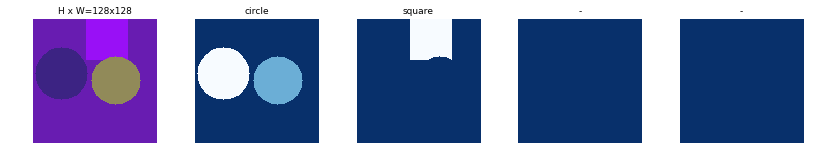

Image id:  15


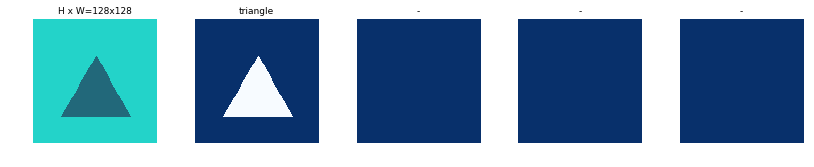

In [5]:
train_batch_x, train_batch_y = next(train_generator)
imgmeta_idx = mm.input_names.index('input_image_meta')
img_meta    = train_batch_x[imgmeta_idx]

image_id = img_meta[0,0]
print('Image id: ',image_id)
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

image_id = img_meta[1,0]
print('Image id: ',image_id)
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [149]:
from mrcnn.callbacks import get_layer_output_1,get_layer_output_2

pp = pprint.PrettyPrinter(indent=4)
# for i in range(len(mm.outputs)): 
#     print('shape of output layer: {}  is {}'.format(i, mm.outputs[i].shape))

# for i in (self.model.input):
    # print('input  type: {}'.format(i.get_shape()))

layers_out = get_layer_output_2(model.keras_model, train_batch_x, 1)

# print('type of layer out is {} shape is {}'.format(type(layer_out), layer_out.shape))


 Input Name:  (input_image             ) 	  Input shape: (2, 128, 128, 3)
 Input Name:  (input_image_meta        ) 	  Input shape: (2, 12)
 Input Name:  (input_rpn_match         ) 	  Input shape: (2, 4092, 1)
 Input Name:  (input_rpn_bbox          ) 	  Input shape: (2, 256, 4)
 Input Name:  (input_gt_class_ids      ) 	  Input shape: (2, 100)
 Input Name:  (input_gt_boxes          ) 	  Input shape: (2, 100, 4)
 Input Name:  (input_gt_masks          ) 	  Input shape: (2, 56, 56, 100)
mrcnn_class shape :  (2, 32, 4) mrcnn_bbox.shape :  (2, 32, 4, 4)
output_rois.shape :  (2, 32, 4) pred_tensor shape:  (2, 4, 32, 8)
[[2 1 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
pcn_tensor :  (2, 4, 32, 8)
pcn_cls_cnt:  (2, 4)
 Build Gaussian NP ==========================
    in_tensor shape is  (2, 4, 32, 8)
 num of bboxes per class is :  32
   _stacked length is  2  shape is  (32, 8)
 ps shape _:  (32, 8)
 psx:  [[  0.

   _stacked length is  2  shape is  (3, 8)
 ps shape _:  (3, 8)
 psx:  [[  0.   1.   0.  55.  42.  98.   1.   0.]
 [  0.   1.  38.  60.  89. 111.   2.   1.]
 [  1.   1.  29.   2.  84.  57.   2.   2.]]
 ps :  [[  0.   1.   0.  55.  42.  98.   1.   0.]
 [  0.   1.  38.  60.  89. 111.   2.   1.]
 [  1.   1.  29.   2.  84.  57.   2.   2.]]
means.shape: (3, 2) cov.shape  (3, 2)
img:  0  cls: 1   0
img:  0  cls: 2   [1 2]
img:  0  cls: 3   []
 ps shape _:  (1, 8)
 psx:  [[  0.   1.  38.  29. 101. 101.   3.   0.]]
 ps :  [[  0.   1.  38.  29. 101. 101.   3.   0.]]
means.shape: (1, 2) cov.shape  (1, 2)
img:  1  cls: 1   []
img:  1  cls: 2   []
img:  1  cls: 3   0

 pred_tensor  <class 'numpy.ndarray'> 
 pred_cls_cnt  <class 'numpy.ndarray'>

 pc_gaussian  <class 'numpy.ndarray'> (2, 4, 128, 128)

 gt_gaussian  <class 'numpy.ndarray'> (2, 4, 128, 128)

 gt_tensor    <class 'numpy.ndarray'> (2, 4, 100, 8)  gt_cls_cnt    <class 'numpy.ndarray'> (2, 4)
 Output Name: (output_rois             ) 	  O

Image id:  383


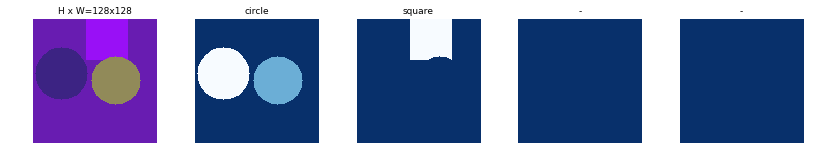

Image id:  15


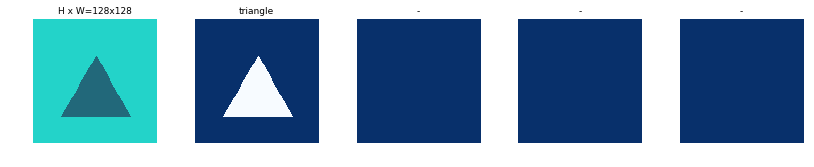

In [143]:
imgmeta_idx = mm.input_names.index('input_image_meta')
img_meta    = train_batch_x[imgmeta_idx]

image_id = img_meta[0,0]
print('Image id: ',image_id)
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

image_id = img_meta[1,0]
print('Image id: ',image_id)
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

<IPython.core.display.Javascript object>


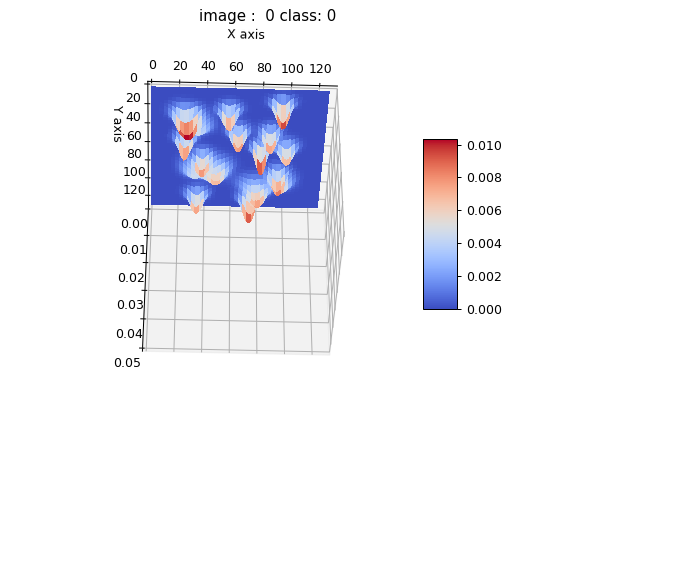

<IPython.core.display.Javascript object>


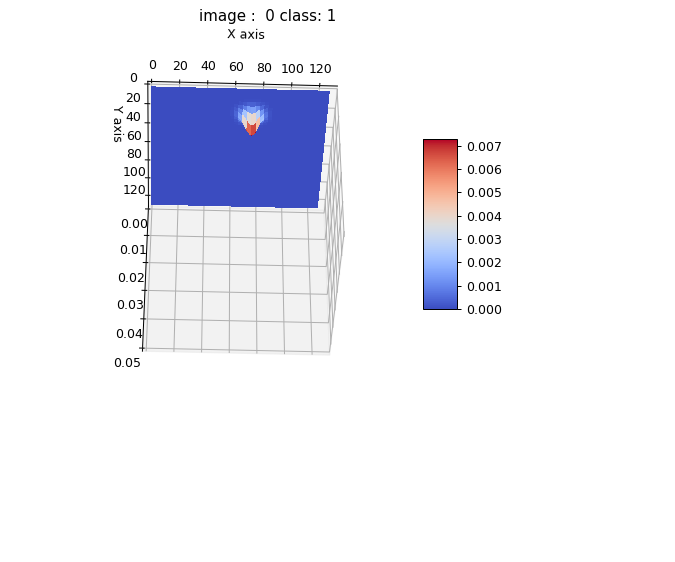

<IPython.core.display.Javascript object>


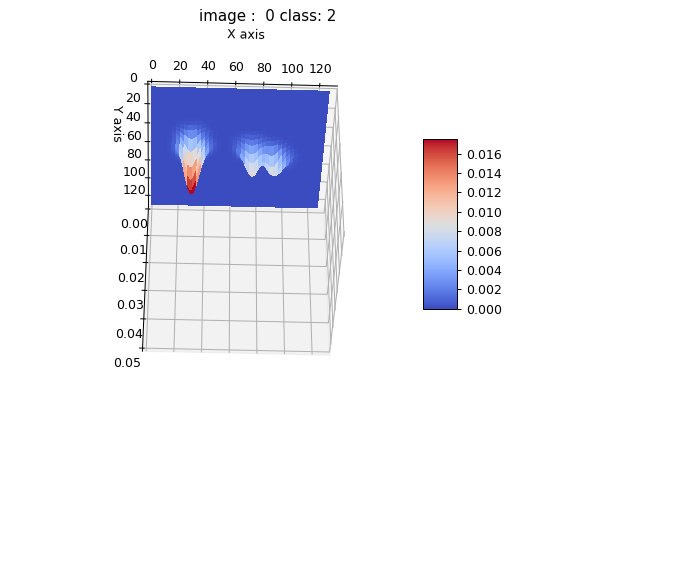

<IPython.core.display.Javascript object>


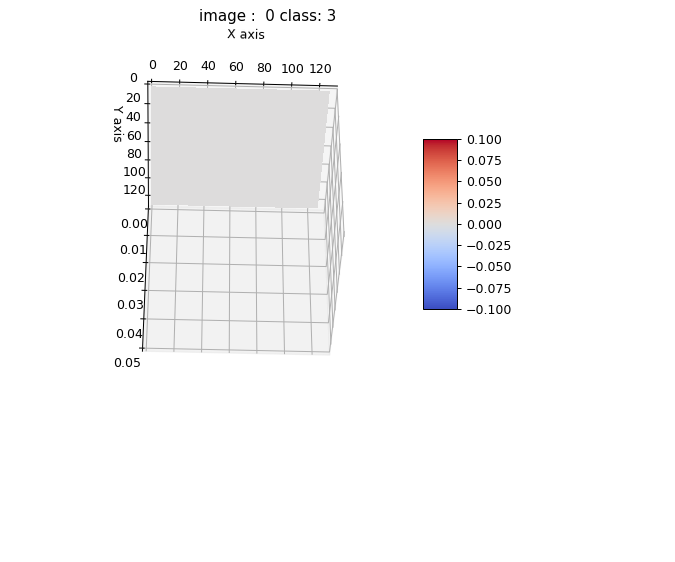

<IPython.core.display.Javascript object>


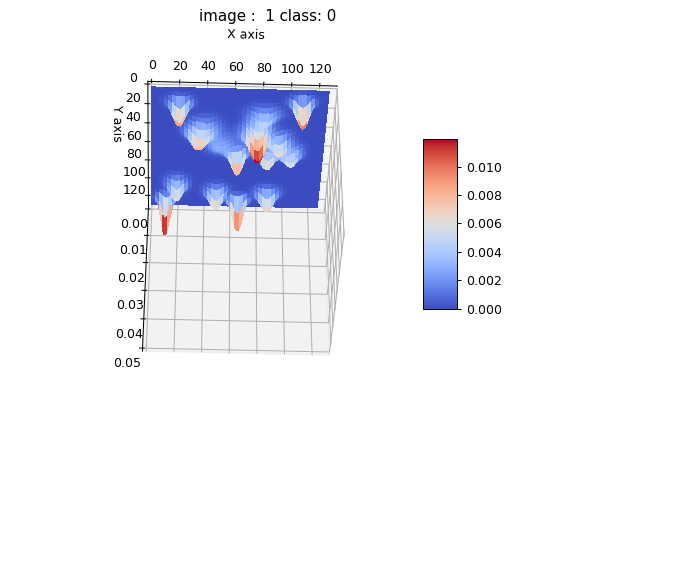

<IPython.core.display.Javascript object>


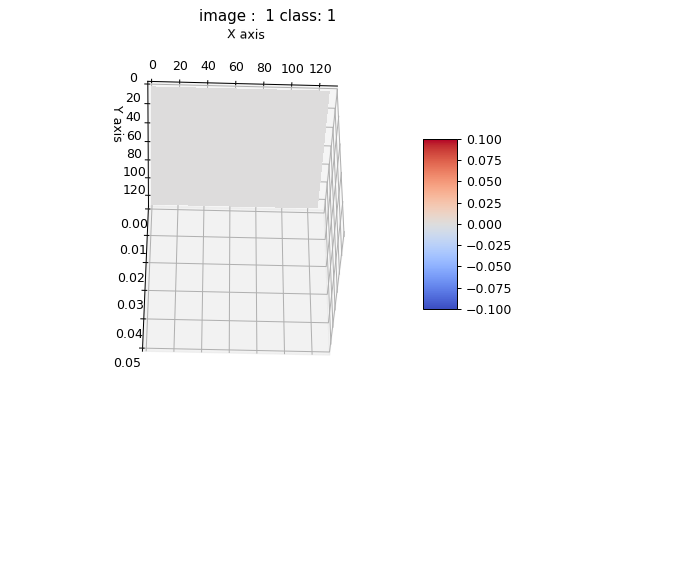

<IPython.core.display.Javascript object>


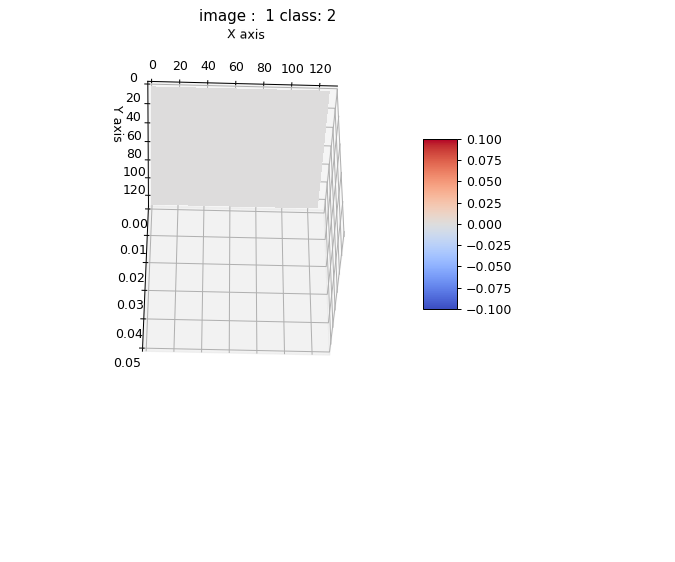

<IPython.core.display.Javascript object>


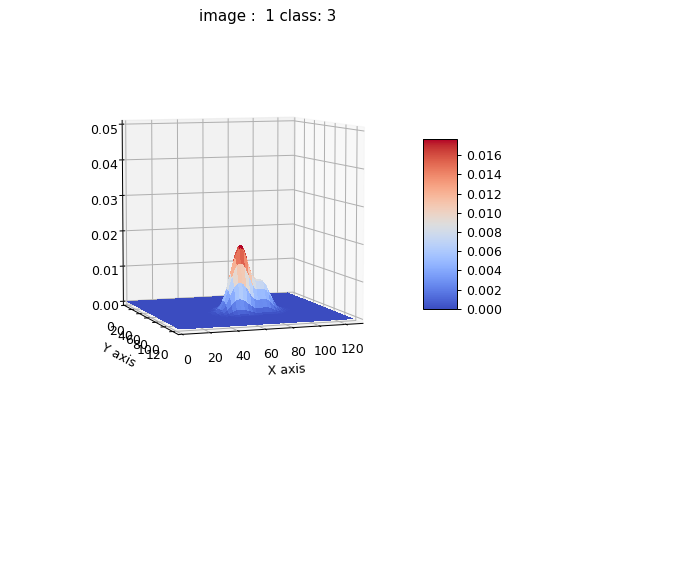

In [150]:
%matplotlib notebook
from mrcnn.visualize import plot_gaussian
Zout = layers_out[1]
num_images = config.IMAGES_PER_GPU
num_classes = config.NUM_CLASSES
for img in range(num_images):
    for cls in range(num_classes):
        ttl = 'image :  {} class: {} '.format(img,cls)
        plot_gaussian(Zout[img,cls], title = ttl)

<IPython.core.display.Javascript object>


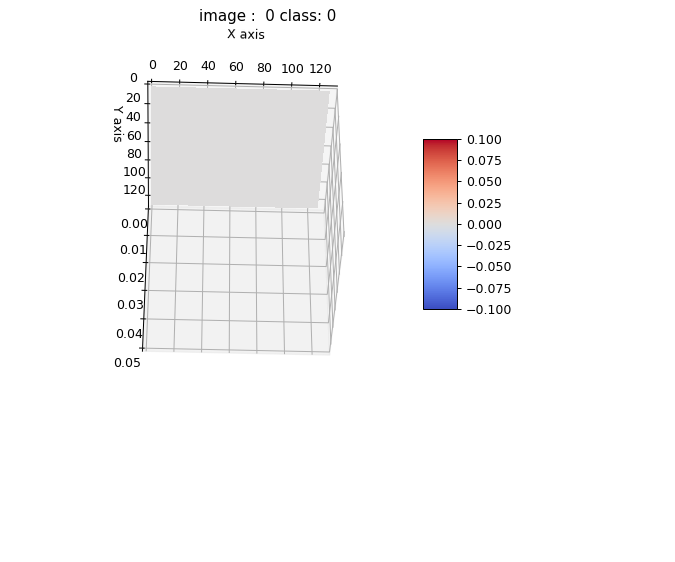

<IPython.core.display.Javascript object>


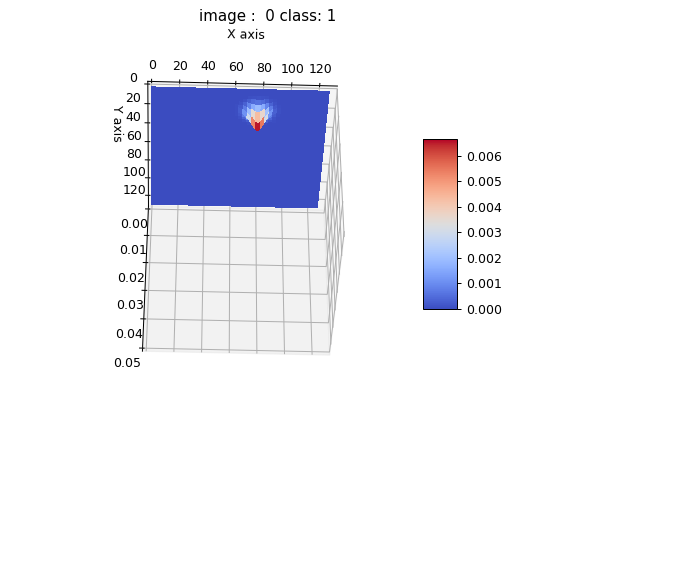

<IPython.core.display.Javascript object>


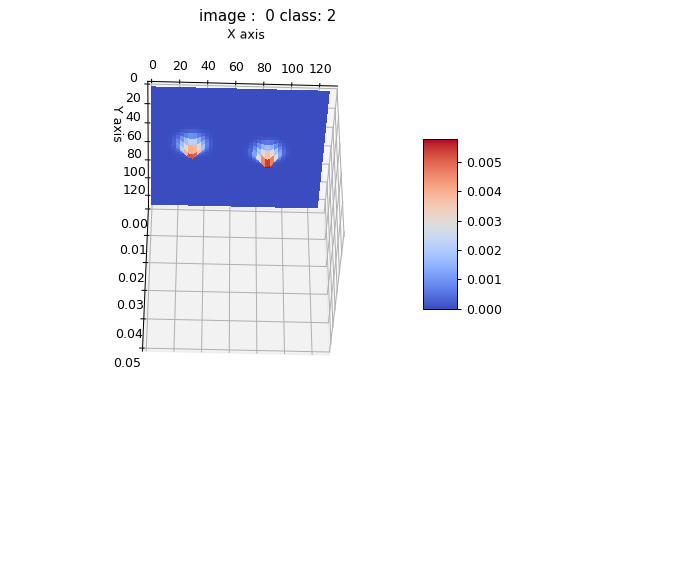

<IPython.core.display.Javascript object>


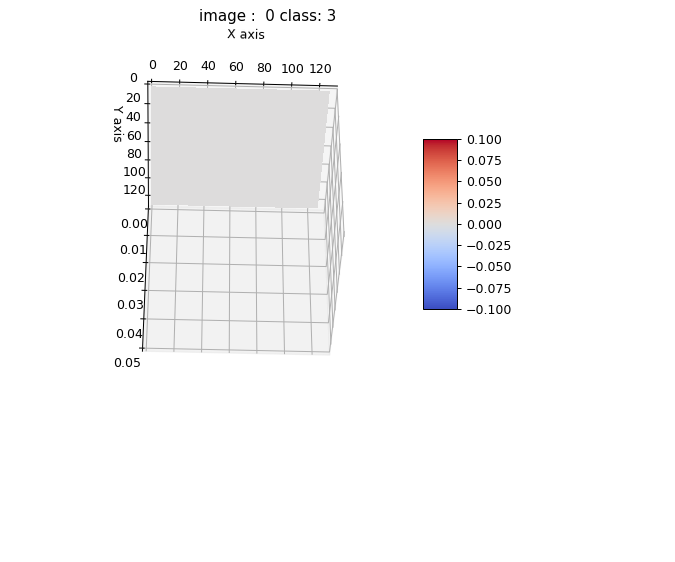

<IPython.core.display.Javascript object>


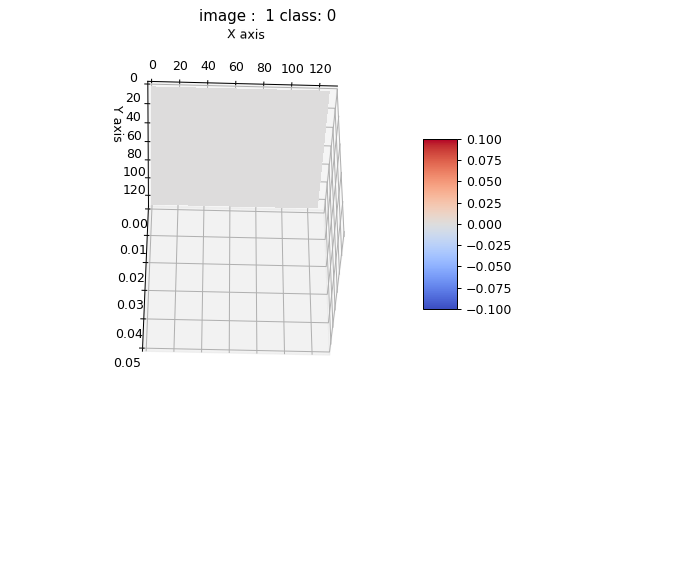

<IPython.core.display.Javascript object>


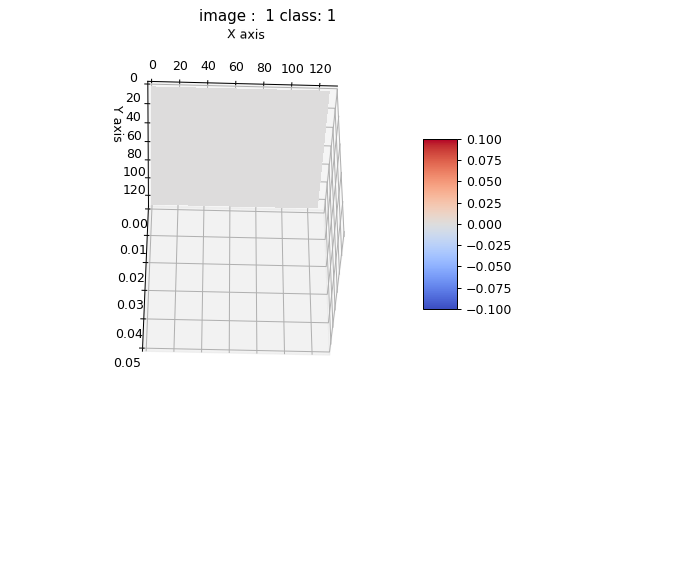

<IPython.core.display.Javascript object>


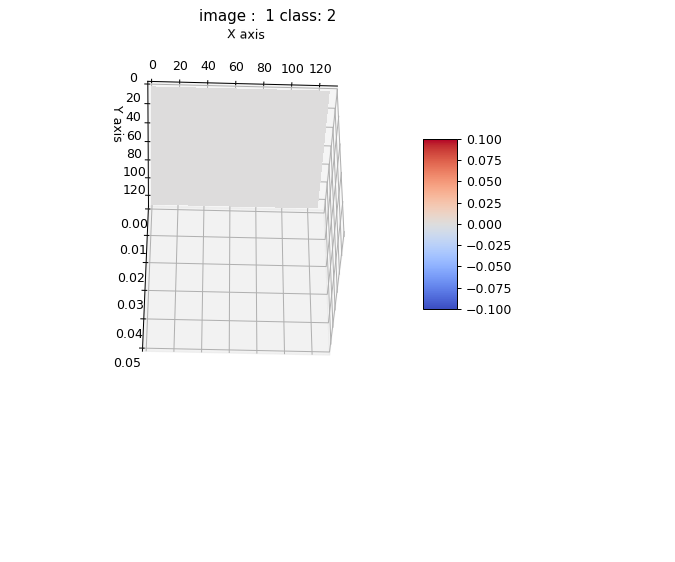

<IPython.core.display.Javascript object>


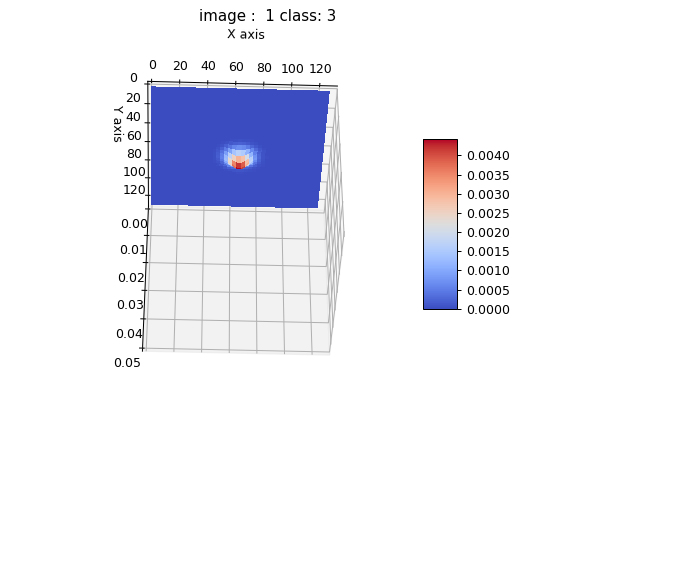

In [151]:
# i = 1
# print(layers_out[i].shape)      #[0,0,0:20, 0:20]
Zout = layers_out[2]
num_images = config.IMAGES_PER_GPU
num_classes = config.NUM_CLASSES
for img in range(num_images):
    for cls in range(num_classes):
        ttl = 'image :  {} class: {} '.format(img,cls)
        plot_gaussian(Zout[img,cls], title = ttl)

In [110]:
from mrcnn.utils import trim_zeros
np.set_printoptions( edgeitems=32, suppress=True)
gt_bb = layers_out[3]
print(gt_bb.shape)
x0 = [ trim_zeros((gt_bb[0,i,:,:])) for i in range(4)]
ps0 = np.concatenate( x0, axis=0 )

x1 = [ trim_zeros((gt_bb[1,i,:,:])) for i in range(4)]
ps1 = np.concatenate( x1, axis=0 )
# print(np.concatenate( x1, axis=0 ))
print(ps0)

(2, 4, 32, 8)
[[  0.          0.9999999 109.639145  105.1487    128.        128.          0.         21.       ]
 [  1.          0.9999989 101.36875    64.41333   128.         97.187195    0.         24.       ]
 [  2.          0.9999986  98.11046    38.66862   128.         76.144714    0.         28.       ]
 [  3.          0.9999949   0.          0.         20.614231   26.543777    0.         25.       ]
 [  4.          0.9998479  67.254486   88.83188   106.87836   128.          0.         26.       ]
 [  5.          0.9998152   0.         29.23845    24.270521   87.70832     0.         23.       ]
 [  6.          0.9997768   0.          0.          0.          0.          0.         30.       ]
 [  7.          0.9997768   0.          0.          0.          0.          0.         31.       ]
 [  8.          0.9997285  85.69699    11.063509  128.         68.14799     0.         15.       ]
 [  9.          0.9997124  52.71115    77.93634    99.96118   123.87713     0.         29.     

In [109]:
print(ps0.shape)
width  = ps0[:,5] - ps0[:,3]
height = ps0[:,4] - ps0[:,2]
cx     = ps0[:,3] + ( width  / 2.0)
cy     = ps0[:,2] + ( height / 2.0)
means0  = np.stack((cx,cy,width, height),axis = -1)
print(means0)

(32, 8)
[[116.57435  118.81957   22.851303  18.360855]
 [ 80.80026  114.68437   32.773865  26.631248]
 [ 57.40667  113.05523   37.476093  29.889542]
 [ 13.271889  10.307116  26.543777  20.614231]
 [108.41594   87.06642   39.16812   39.62387 ]
 [ 58.473385  12.135261  58.46987   24.270521]
 [  0.         0.         0.         0.      ]
 [  0.         0.         0.         0.      ]
 [ 39.60575  106.848495  57.08448   42.30301 ]
 [100.90674   76.33617   45.94079   47.25003 ]
 [ 79.79886   51.66375   27.859215  29.436787]
 [ 49.122612  78.245865  64.556     69.364456]
 [ 64.32202   62.255272  39.214138  39.601185]
 [ 86.5356    41.66272   33.89827   39.47747 ]
 [ 25.848333  95.389206  51.696667  54.600777]
 [ 41.98857   25.275913  48.55858   44.91104 ]
 [ 86.13054   30.839449  30.331429  33.724464]
 [ 62.988693  83.84709   72.933136  72.707886]
 [ 63.784985  69.2075    61.066475  61.734665]
 [ 65.68331   24.882723  37.96376   38.377754]
 [ 61.16785   22.954092  64.00578   45.908184]
 [ 33

In [90]:
print(layers_out[3][1])

[[[  0.       1.       0.       0.      26.6095  40.5494   0.      17.    ]
  [  1.       1.       0.      23.4415  49.1055 104.0768   0.      21.    ]
  [  2.       1.       7.1176  25.0614  60.9052  85.7614   0.      24.    ]
  [  3.       1.       0.       0.       0.       0.       0.      27.    ]
  [  4.       1.       0.       0.       0.       0.       0.      28.    ]
  [  5.       1.       0.       0.       0.       0.       0.      29.    ]
  [  6.       1.       0.       0.       0.       0.       0.      30.    ]
  [  7.       1.       0.       0.       0.       0.       0.      31.    ]
  [  8.       1.       0.       0.      38.0409 104.6174   0.      18.    ]
  [  9.       0.9998  99.1851  69.0267 128.     106.019    0.      10.    ]
  [ 10.       0.9998  21.6654  77.2275  72.0484 128.       0.      16.    ]
  [ 11.       0.9998   9.0991   0.      58.3747  50.3786   0.      15.    ]
  [ 12.       0.9998 107.0064  72.6639 128.     102.377    0.      25.    ]
  [ 13.     

In [115]:
output_rois = layers_out[0]
output_rois[0,:,:]

array([[0.0517894, 0.       , 0.7129905, 0.4639415],
       [0.       , 0.460891 , 0.3182735, 0.9542991],
       [0.       , 0.2278512, 0.3586577, 0.7278965],
       [0.1718844, 0.4350579, 0.7022451, 1.       ],
       [0.0829996, 0.4555586, 0.4083269, 0.77627  ],
       [0.       , 0.4345824, 0.2419978, 0.7817113],
       [0.3107817, 0.       , 0.6807578, 0.348525 ],
       [0.3991938, 0.4476848, 0.7369586, 0.7997175],
       [0.1655341, 0.       , 0.6158789, 0.4100027],
       [0.0009923, 0.3846658, 0.3844073, 0.7560964],
       [0.3316772, 0.3493356, 0.6410614, 0.655696 ],
       [0.2995325, 0.2597793, 0.7818346, 0.7368611],
       [0.2886356, 0.5146036, 0.5186105, 0.7322537],
       [0.0220343, 0.1383538, 0.3729018, 0.5177177],
       [0.1632785, 0.0233172, 0.4965983, 0.3573701],
       [0.6695077, 0.0864337, 1.       , 0.5324062],
       [0.3403409, 0.1315985, 0.8822507, 0.6359423],
       [0.3710402, 0.2072041, 0.9390706, 0.7769942],
       [0.       , 0.0779721, 0.2747339, 0.439

In [123]:
    pp1 = np.full((32), 12.0)
    pp2 = np.full((32), 19.0)
    cov = np.stack((pp1,pp2),axis=-1)
    cov2 = np.ones((32,2))* np.array([15,22])
    print(cov2 * .5)

[[ 7.5 11. ]
 [ 7.5 11. ]
 [ 7.5 11. ]
 [ 7.5 11. ]
 [ 7.5 11. ]
 [ 7.5 11. ]
 [ 7.5 11. ]
 [ 7.5 11. ]
 [ 7.5 11. ]
 [ 7.5 11. ]
 [ 7.5 11. ]
 [ 7.5 11. ]
 [ 7.5 11. ]
 [ 7.5 11. ]
 [ 7.5 11. ]
 [ 7.5 11. ]
 [ 7.5 11. ]
 [ 7.5 11. ]
 [ 7.5 11. ]
 [ 7.5 11. ]
 [ 7.5 11. ]
 [ 7.5 11. ]
 [ 7.5 11. ]
 [ 7.5 11. ]
 [ 7.5 11. ]
 [ 7.5 11. ]
 [ 7.5 11. ]
 [ 7.5 11. ]
 [ 7.5 11. ]
 [ 7.5 11. ]
 [ 7.5 11. ]
 [ 7.5 11. ]]


In [ ]:
# from mrcnn.pc_layer import PCTensor
# np.set_printoptions(precision=4,edgeitems=32)
# pc_tensor = PCTensor(model)
# pc_tensor.build_predictions(train_batch_x)
# # pc_tensor.pred_tensor[1]
# pc_tensor.pred_stacked[0]

### Display ground truth bboxes using load_image_gt

Here we are displaying the ground truth bounding boxes as provided by the dataset

Image id:  383
[[  0  55  42  98]
 [ 38  60  89 111]
 [ 29   2  84  57]]
Image id:  15
[[ 38  29 101 101]]


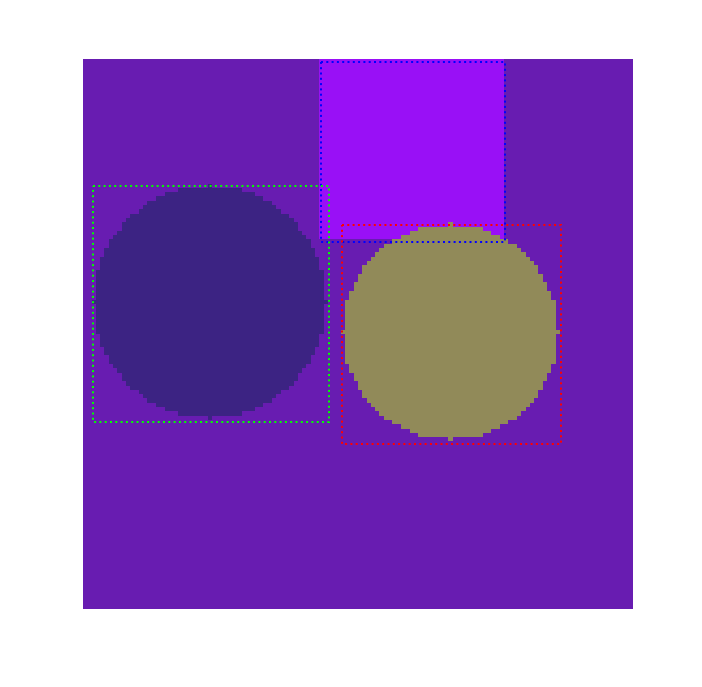

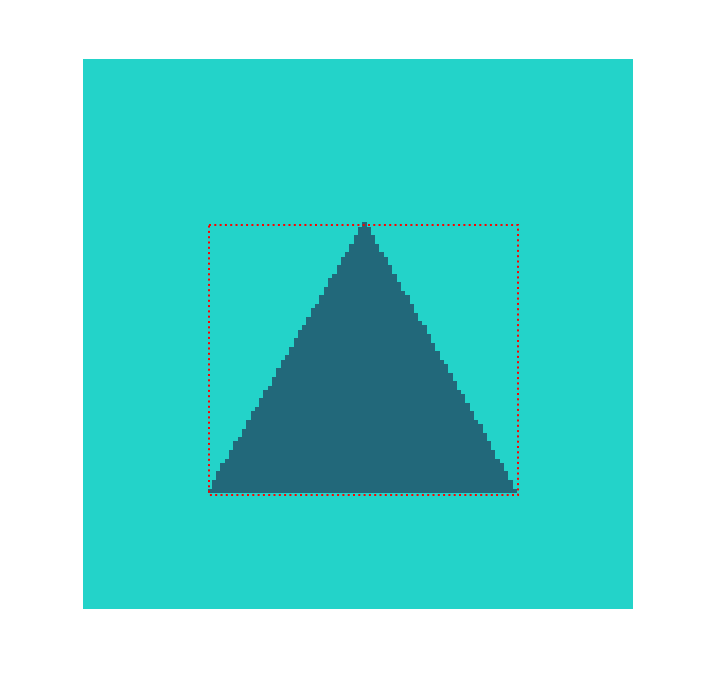

In [42]:
image_id = img_meta[0,0]
print('Image id: ',image_id)
p_original_image, p_image_meta, p_gt_class_id, p_gt_bbox, p_gt_mask =  \
            load_image_gt(dataset_train, config, image_id, augment=False, use_mini_mask=True)
# print(p_gt_class_id.shape, p_gt_bbox.shape, p_gt_mask.shape)
print(p_gt_bbox)
visualize.draw_boxes(p_original_image, p_gt_bbox)

image_id = img_meta[1,0]
print('Image id: ',image_id)
p_original_image, p_image_meta, p_gt_class_id, p_gt_bbox, p_gt_mask =  \
            load_image_gt(dataset_train, config, image_id, augment=False, use_mini_mask=True)
# print(p_gt_class_id.shape, p_gt_bbox.shape, p_gt_mask.shape)
print(p_gt_bbox)
visualize.draw_boxes(p_original_image, p_gt_bbox)

### Display bboxes from Ground Truth Info Passed to Net

Display the Ground Truth bounding boxes from the tensor we've constructed

In [65]:
np.set_printoptions(linewidth=120, precision=5)
gt_bboxes = layers_out[5]
print(layers_out[5].shape)
print(layers_out[6])
print(layers_out[5][1,3])

(2, 4, 100, 8)
[[0 1 2 0]
 [0 0 0 1]]
[[  0.   1.  38.  29. 101. 101.   3.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.

Image id:  383
[[ 0. 55. 42. 98.]]
[[ 38.  60.  89. 111.]
 [ 29.   2.  84.  57.]]


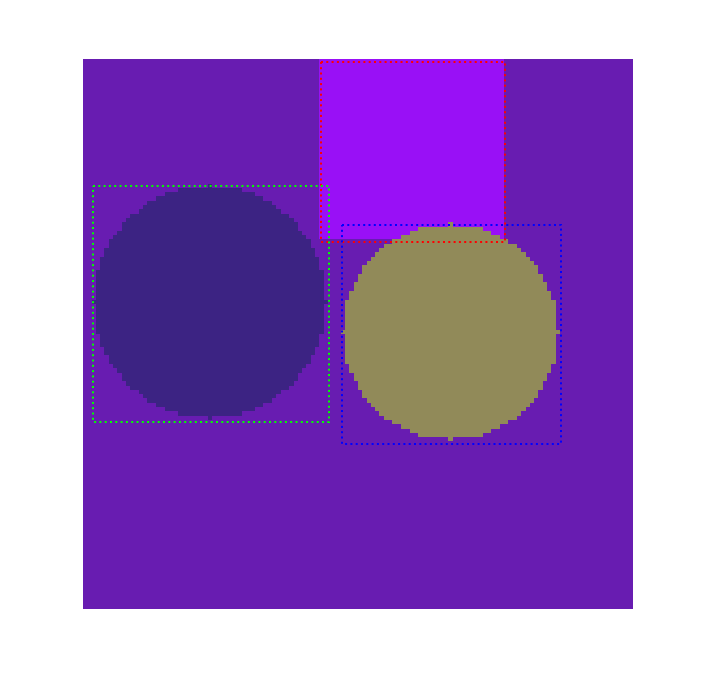

In [55]:
# print(gt_bboxes)
# visualize.display_instances(p_original_image, p_gt_bbox, p_gt_mask, p_gt_class_id, 
#                             dataset_train.class_names, figsize=(8, 8))
# pp.pprint(gt_bboxes)
image_id = img_meta[0,0]
print('Image id: ',image_id)
p_image, p_image_meta, p_gt_class_id, p_gt_bbox, p_gt_mask =  \
            load_image_gt(dataset_train, config, image_id, augment=False, use_mini_mask=True)
gt_bboxes = layers_out[5]
print(gt_bboxes[0,1,0:1,2:6])
print(gt_bboxes[0,2,0:2,2:6])
gt_bb = np.vstack((gt_bboxes[0,1,0:1,2:6],gt_bboxes[0,2,0:2,2:6]))
gt_bb.shape
visualize.draw_boxes(p_image, gt_bb)

## Display RoI proposals generated

Display bounding boxes from tensor of proposals produced by the network 

In [ ]:
img = 1
cls = 3
caps = [str(x) for x in pc_tensor.pred_tensor[img,cls,:,0].astype('int16').tolist() ]
print(caps)
# print(pc_tensor.pred_tensor[1,3,:])
# print(pc_tensor.pred_tensor[1,3,:,2:6])
visualize.draw_boxes(image, pc_tensor.pred_tensor[img,cls,:,2:6], captions = caps)

For each class:
- determine the center of each bounding box.
- center a 2d gaussian distribution with the mean = center of bounding box and sigma = height/width
- place dist on mesh grid
- normalize
- draw heatmap

In [ ]:
np.set_printoptions(precision=5)
from mrcnn.pc_layer import PCTensor
pc_tensor = PCTensor(model)
pc_tensor.build_predictions(sample_x)
print(pc_tensor.pred_stacked)    # list of tensors


In [ ]:
Zout2 = pc_tensor.build_gaussian_np()

### Plot

In [ ]:
from mrcnn.visualize import plot_gaussian
num_images = config.IMAGES_PER_GPU
num_classes = config.NUM_CLASSES
for img in range(num_images):
    for cls in range(num_classes):
        ttl = 'image :  {} class: {} '.format(img,cls)
        plot_gaussian(Zout1[img,cls], title = ttl)
#     print(Zout.shape)
# plot_gaussian(Zout)
# Zout = pc_tensor.build_gaussian()

In [ ]:
from mrcnn.visualize import plot_gaussian
num_images = config.IMAGES_PER_GPU
num_classes = config.NUM_CLASSES
for img in range(num_images):
    for cls in range(num_classes):
        ttl = 'image :  {} class: {} '.format(img,cls)
        plot_gaussian(Zout[img,cls], title = ttl)
#     print(Zout.shape)
# plot_gaussian(Zout)
# Zout = pc_tensor.build_gaussian()

In [ ]:
# img = 0
# cls = 0
# _cnt = pc_tensor.pred_cls_cnt[img,cls]
# print(_cnt)
# for box in range(_cnt):

#     mns = means[img,cls, 0 : _cnt]
#     print('img: ',img, 'class: ', cls, 'class count: ',_cnt, 'shape of mns :',mns.shape)
#     # print('** bbox is : ' ,self.pred_tensor[img,cls,box])
#     # print('    center is ({:4f},{:4f})  width is {:4f} height is {:4f} '\
#         # .format(mns[0],mns[1],width[img,cls,box],height[img,cls,box]))            
#     # fn = lambda x: multivariate_normal(x, [[12,0.0] , [0.0,19]])
#     # rv = tf.map_fn(fn, 
#     rv = np.apply_along_axis(multivariate_normal, 1, mns, [[12,0.0] , [0.0,19]])
#     print('rv :',rv.shape, rv)
#     _zo = rv.pdf(pos[img,cls])
#     print('zo :',_zo.shape)

In [ ]:
# pc_tensor.pred_stacked[0].eval(session=k_sess)
#

In [ ]:
tfd = tf.contrib.distributions
k_sess = KB.get_session()

In [ ]:
# pp1 = tf.fill([1,1,32], 12.0)
# pp2 = tf.fill([1,1,32], 19.0)
# pp  = tf.cast(tf.stack((pp1,pp2),axis=-1), dtype=tf.float64)
# tf.cast([12.0, 19.00], dtype=tf.float64)
# pp1.eval(session = k_sess)

# mvn = tfd.MultivariateNormalDiag(means[0,0,0,:],scale_diag=p1)
# mvn = tfd.MultivariateNormalDiag(means[0,0,0,:],scale_diag=p1)

# with k_sess.as_default():
#     print(mvn.mean())
#     print(mvn.batch_shape)
#     print(mvn.event_shape)
#     print(pos[0,0,:,0,0,:].shape)
#     rr = mvn.prob(pos[0,0,:,0,0,:])
#     print(rr)

In [ ]:
# %matplotlib notebook
# from mrcnn.visualize import plot_gaussian
# for i in range(0,config.IMAGES_PER_GPU):
#     for j in range(0,config.NUM_CLASSES):
#         ttl = 'image : {} class: {}'.format(i,j)
#         plot_gaussian(Zout[i,j] , title = ttl )
# # plot_gaussian(Zout[3])


In [ ]:
# Zout = np.zeros((num_classes, 128,128))
for i in range(1,config.NUM_CLASSES):
    print('class: ',i)
    for j in range(gt_cls_cnt[i]):
        Zout[i] = bbox_gaussian(gt_cpb[i,j], Zout[i])
print(Zout.shape)
 
# plot_gaussian(Zout[1])
# plot_gaussian(Zout[3])

## Fine Tuning
Fine tune all layers

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=211,
            layers="all")

## Save 

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
model.keras_model.save_weights(model_path)

## Detection

In [ ]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

In [ ]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)

original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_bbox)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [ ]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id,
                         r["rois"], r["class_ids"], r["scores"])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

In [ ]:
# lay = mm.layers[229]
# print(lay.__class__, lay.__class__.__name__)
# pp.pprint(dir(lay))
# pp.pprint(lay.input_spec.__dict__)
# pp.pprint(lay.output.__dict__)
# print(type(lay.output))
# print(keras.backend.is_keras_tensor(lay))
# print(K.eval(lay.output))

In [ ]:
# print(pred_index.shape, pred_class.shape, pred_prob.shape)
# b_cpb = np.column_stack((pred_index, pred_class, pred_prob, rois)) # , b_probs)) #.transpose()
# print(' b_cpb shape: ',b_cpb.shape,'\n',b_cpb)

# print(b_cpb[:,3:] bbox_delta)

# nonbg_idx = np.argwhere(b_cpb[:,1]) 

# print(type(nonbg_idx))
# b_cpb_nonbg = b_cpb[nonbg_idx,:].squeeze()

# print(b_cpb_nonbg)
# order = b_cpb_nonbg[:,2].argsort()



# print('\n srtd_cpb : (idx, class, prob, y1, x1, y2, x2)',srtd_cpb.shape, '\n')
# print(srtd_cpb)

# # srtd_cpb_2 has (idx, cls_idx, prob, cx ,cy, width, height) instead of (idx, cls_idx, prob, y1, x1, y2, x2)

# width  = srtd_cpb[:,6]-srtd_cpb[:,4]
# height = srtd_cpb[:,5]-srtd_cpb[:,3]
# cx = srtd_cpb[:,4] + ( width  / 2.0)
# cy = srtd_cpb[:,3] + ( height / 2.0)
# print('\n srtd_cpb_2 : (idx, class, prob, cx ,cy, width, height) instead of (y1, x1, y2, x2)')
# srtd_cpb_2 = np.column_stack((srtd_cpb[:, 0:3], cx,cy, width, height ))

# print('\n',srtd_cpb_2)

### Scrap Code

In [ ]:
# def get_layer_output(model, model_input,output_layer, training_flag = True):
#     _my_input = model_input 
#     for name,inp in zip(model.input_names, model_input):
#         print(' Input Name:  ({:24}) \t  Input shape: {}'.format(name, inp.shape))


#     _mrcnn_class = KB.function(model.input , model.output)
#     output = _mrcnn_class(_my_input)                  
    
#     for name,out in zip (model.output_names,output):
#         print(' Output Name: ({:24}) \t Output shape: {}'.format(name, out.shape))
#     return output

In [ ]:
def stack_tensor(model):
    pred_cpb_all = np.empty((0,8))
    for i in range(1,model.config.NUM_CLASSES):
    if pred_cls_cnt[i] > 0:
        pred_cpb_all = np.vstack((pred_cpb_all, pred_cpb[i,0:pred_cls_cnt[i]] ))
    

In [ ]:
from scipy.stats import  multivariate_normal
import numpy as np
def bbox_gaussian( bbox, Zin ):
    """
    receive a bounding box, and generate a gaussian distribution centered on the bounding box and with a 
    covariance matrix based on the width and height of the bounding box/. 
    Inputs : 
    --------
    bbox :  (index, class_id, class_prob, y1, x1, y2, x2)
    bbox :  (index, class_id, class_prob, cx, cy, width, height)
    Returns:
    --------
    bbox_g  grid mesh [image_height, image width] covering the distribution

    """
    print(bbox.shape)
    width  = bbox[6] - bbox[4]
    height = bbox[5] - bbox[3]
    cx     = bbox[4] + ( width  / 2.0)
    cy     = bbox[3] + ( height / 2.0)
#     cx, cy, width, height = bbox[3:]
    print('center is ({},{}) width: {}  height: {} '.format(cx, cy, width,  height))
#     srtd_cpb_2 = np.column_stack((srtd_cpb[:, 0:2], cx,cy, width, height ))
    X = np.arange(0, 128, 1)
    Y = np.arange(0, 128, 1)
    X, Y = np.meshgrid(X, Y)
    pos = np.empty(X.shape+(2,))   # concatinate shape of x to make ( x.rows, x.cols, 2)
    pos[:,:,0] = X;
    pos[:,:,1] = Y;

    rv = multivariate_normal([cx,cy],[[12,0.0] , [0.0,19]])
    Zout  = rv.pdf(pos)
    Zout += Zin
    return Zout

## Notebook Preferences

In [ ]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Configurations

In [ ]:
# from keras import backend as KB
# if 'tensorflow' == KB.backend():
#     import tensorflow as tf
#     from keras.backend.tensorflow_backend import set_session
#     # tfconfig = tf.ConfigProto(
#         # gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5),
#         # device_count = {'GPU': 1}
#     # )    
#     tfconfig = tf.ConfigProto()
#     tfconfig.gpu_options.allow_growth=True
#     tfconfig.gpu_options.visible_device_list = "0"
#     tfconfig.gpu_options.per_process_gpu_memory_fraction=0.5
#     tf_sess = tf.Session(config=tfconfig)
#     set_session(tf_sess)

### Prepare Prediction Tensor (output tensor)
Using the softmax outputs from the mrcnn head of the network and predicted RoIs , 
build tensor [ num-classes, num_rois, (roi_information) ]

In [ ]:
# np.set_printoptions(precision=4)

# // pass model to TensorBuilder

# h, w = config.IMAGE_SHAPE[:2]

# class_idx = mm.output_names.index('mrcnn_class')
# bbox_idx  = mm.output_names.index('mrcnn_bbox')
# outroi_idx= mm.output_names.index('output_rois')


# print('mrcnn_class idx: {}   mrcnn_bbox idx : {}   output_rois idx : {}'.format(class_idx, bbox_idx,outroi_idx))


# mrcnn_class = ppp[class_idx]
# mrcnn_bbox  = ppp[bbox_idx]
# rois_norm   = ppp[outroi_idx][0,...] 
# rois        = rois_norm * np.array([h,w,h,w])

# num_classes = config.NUM_CLASSES
# num_rois    = config.TRAIN_ROIS_PER_IMAGE
# num_max_gt  = config.DETECTION_MAX_INSTANCES
# num_cols    = 8 

# pred_arr    = np.zeros((num_classes, num_rois, num_cols ))      # 4, 32, 7
# pred_cpb    = np.zeros_like(pred_cpb)
# pred_cls_cnt= np.zeros((num_classes), dtype='int16')

# print(' mrcnn_bbox shape is : ',mrcnn_bbox.shape, ' pred_cpb shape is   : ',pred_cpb.shape  )

# # use the argmaxof each row to determine the dominating (predicted) class
# #---------------------------------------------------------------------------
# pred_class = np.argmax(mrcnn_class[0,:,:],axis=1).astype('int16')   # (32,)

# # pred_index = np.arange(pred_class.shape[0],dtype='int16')
# # pred_prob  =    np.max(mrcnn_class[0,:,:],axis=1)                   #  (32,)
# # dont need it for now. Need to see if and how we should apply  the delta to the bounding box coords
# # pred_delta   = mrcnn_bbox[0,pred_index[:],pred_class[:],:]        

# for i in range(num_classes) :
#     class_idxs = np.argwhere(pred_class == i )
#     pred_cls_cnt[i] = class_idxs.shape[0] 
#     for j , c_idx in enumerate(class_idxs):
#         pred_arr[i, j,  0]  = j
#         pred_arr[i, j,  1]  = i                                   # class_id
#         pred_arr[i, j,  2]  = np.max(mrcnn_class[0, c_idx ])      # probability
#         pred_arr[i, j,3:7]  = rois[c_idx]                         # roi coordinates
#         pred_arr[i, j,  7]  = c_idx                               # index from mrcnn_class array (temp for verification)
        
        
# # sort each class in descending prediction order 

# order = pred_arr[:,:,2].argsort()

# for i in range(num_classes):
#     pred_cpb[i,:,1:] =  pred_arr[i,order[i,::-1],1:]      
# pred_cpb[:,:,0] = pred_arr[:,:,0]

# print('pred_cpb shape', pred_cpb.shape)

# print(pred_cpb_all)

# Display values for sanity check 
# i = 0
# print(pred_cls_cnt)
# print(' pred_cpb ')
# print(pred_cpb[i])
# print(' pred_srtd ')
# print(pred_srtd[i])

### Prepare output tensor from Ground Truth data 

Using ground truth inputs to the network, build tensor [ num-classes, num_rois, (roi_information) ]
This Tensor will be used for training purposed on the new head we will be attaching to the existing network 

In [ ]:
# gtcls_idx = mm.input_names.index('input_gt_class_ids')
# gtbox_idx = mm.input_names.index('input_gt_boxes')
# gtmsk_idx = mm.input_names.index('input_gt_masks')
# print('gtcls_idx: ',gtcls_idx, 'gtbox_idx :', gtbox_idx)
# gt_classes = sample_x[gtcls_idx][0,:]
# gt_bboxes  = sample_x[gtbox_idx][0,:,:]

# gt_cpb     = np.zeros((num_classes, num_max_gt, num_cols ))      # 4, 32, 7
# gt_cls_cnt = np.zeros((num_classes), dtype='int16')
# # gt_masks   = sample_x[gtmsk_idx][0,:,:,nz_idx]
# # gt_indexes = np.arange(gt_classes.shape[0],dtype='int16')
# # gt_probs   = np.ones(gt_classes.shape[0])

# print('gt_classes.shape :',gt_classes.shape, 'gt_boxes.shape :',gt_bboxes.shape,'gt_masks.shape :', gt_masks.shape)
 
# for i in range(num_classes) :
#     print('indexes for class',i )
#     class_idxs = np.argwhere(gt_classes == i )
#     gt_cls_cnt[i] = class_idxs.shape[0]
#     for j , c_idx in enumerate(class_idxs):
#         gt_cpb[i, j,  0]  = j
#         gt_cpb[i, j,  1]  = i                                   # class_id
#         gt_cpb[i, j,  2]  = 1.0                                 # probability
#         gt_cpb[i, j, 3:7] = gt_bboxes[c_idx,:]                         # roi coordinates
#         gt_cpb[i, j,  7]  = c_idx                               # index from mrcnn_class array (temp for verification)

# gt_cpb_all = np.empty((0,8))
# for i in range(1,num_classes):
#     if gt_cls_cnt[i] > 0:
#         gt_cpb_all = np.vstack((gt_cpb_all, gt_cpb[i,0:gt_cls_cnt[i]] ))
# print(gt_cpb_all)

# print('\n gt_cpb : (idx, class, prob, y1, x1, y2, x2)', gt_cpb.shape, '\n')
# print(gt_cls_cnt)
# print(gt_cpb[3])

In [ ]:
# pdf = np.apply_along_axis(lambda x: x.pdf, 0, rv)

rv = list( map(multivariate_normal, mns, pp))
print(type(rv),len(rv))
pdf = list(map(lambda x: x.pdf, rv,  ))
# z =  fn.pdf(pos[img,cls])
# np.sum(pc_tensor.pred_cls_cnt,axis=1)    sum class counts across images
# pc_tensor.pred_cls_cnt[1,0] = 9  # manipulate the class counts for class 0 - just to check


In [ ]:
from scipy.stats import  multivariate_normal
import pprint
pp = pprint.PrettyPrinter(indent=2, width=100)

img_h, img_w = config.IMAGE_SHAPE[:2]
num_images   = config.BATCH_SIZE
num_classes  = config.NUM_CLASSES  
num_rois     = config.TRAIN_ROIS_PER_IMAGE
#   print(bbox.shape)

X = np.arange(0, img_w, 1)
Y = np.arange(0, img_h, 1)
X, Y = np.meshgrid(X, Y)
pos = np.empty((num_rois,) + X.shape + (2,))   # concatinate shape of x to make ( x.rows, x.cols, 2)
print(pos.shape)
pos[:,:,:,0] = X;
pos[:,:,:,1] = Y;

pp1 = np.full((32), 12.0)
pp2 = np.full((32), 19.0)
cov  = np.stack((pp1,pp2),axis=-1)

del pp1,pp2
print(cov.shape, prt[0].shape, prt[1].shape)

prt = pc_tensor.pred_stacked
Zout  = np.zeros((num_images, num_classes, img_w, img_h))

for img in range(num_images):
    ps     = prt[img].eval(session=k_sess)
    
    for cls in range(num_classes):
        cls_idxs = np.argwhere(_ps[:,6] == cls).squeeze() 
#         ps = _ps[cls_idxs,:]        
        print('cl;s:',cls,' ',cls_idxs)
        width  = ps[:,5] - ps[:,3]
        height = ps[:,4] - ps[:,2]
        cx     = ps[:,3] + ( width  / 2.0)
        cy     = ps[:,2] + ( height / 2.0)
        means  = np.stack((cx,cy),axis = -1)

        print(ps.shape, type(ps),width.shape, height.shape, cx.shape, cy.shape, type(means),means.shape)
    
        rv  = list( map(multivariate_normal, means, cov))
        pdf = list( map(lambda x,y: x.pdf(y) , rv, pos))
        pdf_arr = np.asarray(pdf)
        print(pdf_arr.shape)
        pdf_sum = np.sum(pdf_arr[[cls_idxs]],axis=0)
        Zout[img,cls] += pdf_sum


In [ ]:
# import tensorflow as tf

# p = tf.Variable(pc_tensor.pred_tensor)
# q = tf.concat(pc_tensor.pred_stacked,0)
# init=tf.global_variables_initializer()
# with tf.Session() as sess:
#     sess.run(init)
#     print(p.eval())
#     rec=sess.run(recall)
#     print(rec)


# sess = tf.InteractiveSession()
# with sess.as_default():
#     sess.run(init)
#     # a = tf.constant(pc_tensor.pred_tensor)
#     print(type(p))
#     #  tf.assign(p, a)
#     print(p[1,1,:,:].eval())
#     print(p[:,:,:,1].eval())
#     sort_idx = tf.nn.top_k(p[:,:,:,1], k=32).indices
#     print(sort_idx.eval())
#     print(p.shape)
#     p_sorted[0] = tf.gather(p[0],sort_idx[0],axis = 2)
#     print(p_sorted.eval())
#     print(q.shape)
#     print(q.eval())
# sess.close()

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

### Training head using  Keras.model.fit_generator()

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.

model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=69, 
            layers='heads')

### Training heads using train_on_batch()

We need to use this method for the time being as the fit generator does not have provide EASY access to the output in Keras call backs. By training in batches, we pass a batch through the network, pick up the generated RoI detections and bounding boxes and generate our semantic / gaussian tensors ...



In [ ]:
model.train_in_batches(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs_to_run = 2,
            layers='heads')

### Simulate one training iteration

In [ ]:
from mrcnn.datagen import data_generator, load_image_gt
np.set_printoptions(linewidth=100)
learning_rate=model.config.LEARNING_RATE
epochs_to_run = 2
layers='heads'
batch_size = 0
steps_per_epoch = 0
# assert self.mode == "training", "Create model in training mode."
# Pre-defined layer regular expressions
layer_regex = {
    # all layers but the backbone
    "heads": r"(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)",
    # From a specific Resnet stage and up
    "3+": r"(res3.*)|(bn3.*)|(res4.*)|(bn4.*)|(res5.*)|(bn5.*)|(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)",
    "4+": r"(res4.*)|(bn4.*)|(res5.*)|(bn5.*)|(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)",
    "5+": r"(res5.*)|(bn5.*)|(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)",
    # All layers
    "all": ".*",
}

if layers in layer_regex.keys():
    layers = layer_regex[layers]
if batch_size == 0 :
    batch_size = model.config.BATCH_SIZE            
if steps_per_epoch == 0:
    steps_per_epoch = model.config.STEPS_PER_EPOCH

# Data generators
train_generator = data_generator(dataset_train, model.config, shuffle=True,
                                 batch_size=batch_size)
val_generator   = data_generator(dataset_val, model.config, shuffle=True,
                                 batch_size=batch_size,
                                 augment=False)

# Train
log("Last epoch completed : {} ".format(model.epoch))
log("Starting from epoch {} for {} epochs. LR={}".format(model.epoch, epochs_to_run, learning_rate))
log("Steps per epoch:    {} ".format(steps_per_epoch))
log("Batchsize      :    {} ".format(batch_size))
log("Checkpoint Folder:  {} ".format(model.checkpoint_path))
epochs = model.epoch + epochs_to_run

from tensorflow.python.platform import gfile
if not gfile.IsDirectory(model.log_dir):
    log('Creating checkpoint folder')
    gfile.MakeDirs(model.log_dir)
else:
    log('Checkpoint folder already exists')

model.set_trainable(layers)            
model.compile(learning_rate, model.config.LEARNING_MOMENTUM)        

out_labels = model.keras_model._get_deduped_metrics_names()
callback_metrics = out_labels + ['val_' + n for n in out_labels]

progbar = keras.callbacks.ProgbarLogger(count_mode='steps')
progbar.set_model(model.keras_model)
progbar.set_params({
    'epochs': epochs,
    'steps': steps_per_epoch,
    'verbose': 1,
    'do_validation': False,
    'metrics': callback_metrics,
})

progbar.set_model(model.keras_model) 

chkpoint = keras.callbacks.ModelCheckpoint(model.checkpoint_path, 
                                           monitor='loss', verbose=1, save_best_only = True, save_weights_only=True)
chkpoint.set_model(model.keras_model)

progbar.on_train_begin()
epoch_idx = model.epoch

In [ ]:
if epoch_idx >= epochs:
    print('Final epoch {} has already completed - Training will not proceed'.format(epochs))

# while epoch_idx < epochs :
progbar.on_epoch_begin(epoch_idx)
steps_index = 0
# for steps_index in range(steps_per_epoch):

batch_logs = {}
print(' self.epoch {}   epochs {}  step {} '.format(model.epoch, epochs, steps_index))
batch_logs['batch'] = steps_index
batch_logs['size']  = batch_size
progbar.on_batch_begin(steps_index, batch_logs)

In [ ]:
train_batch_x, train_batch_y = next(train_generator)

In [ ]:
imgmeta_idx= model.keras_model.input_names.index('input_image_meta')
img_meta  =  train_batch_x[imgmeta_idx]

image_id = img_meta[0,0]
print('Image id: ',image_id)
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

image_id = img_meta[1,0]
print('Image id: ',image_id)
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [ ]:
outs = model.keras_model.train_on_batch(train_batch_x, train_batch_y)

In [ ]:
if not isinstance(outs, list):
    outs = [outs]
for l, o in zip(out_labels, outs):
    batch_logs[l] = o

    progbar.on_batch_end(steps_index, batch_logs)

        # print(outs)
    progbar.on_epoch_end(epoch_idx, {})
    # if (epoch_idx % 10) == 0:
    chkpoint.on_epoch_end(epoch_idx  , batch_logs)
    epoch_idx += 1

# if epoch_idx != self.epoch:
# chkpoint.on_epoch_end(epoch_idx -1, batch_logs)
model.epoch = max(epoch_idx - 1, epochs)

print('Final : self.epoch {}   epochs {}'.format(model.epoch, epochs))
# end if (else)